# An exploratory data analysis on NY Airbnbs

Date created: 03/23/2020 <br>
Date finished: 03/25/2020 <br>
Status: *FINISHED*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})

import json
import requests
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import folium

from sklearn import preprocessing
from sklearn.cluster import KMeans

In [2]:
# connect to foursquare API
CLIENT_ID = 'DVK0H0D40F4ZSWWVIZJH4G4Y0UVVIE3G1OVIUOC1JJV1XYNM' # Foursquare ID
CLIENT_SECRET = '13DG52BAULCEYTLETTRQFBMRBAAR333MIIR5BKGHAXCP5QL2' # your Foursquare Secret
VERSION = '20200325'

<a id='item1'></a>

## Load and explore the data

In [3]:
df = pd.read_csv('AB_NYC_2019.csv')

In [4]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Get data only for Manhattan.

In [5]:
manhattan_data = df[df['neighbourhood_group'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
3,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
4,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220


In [6]:
manhattan_data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [7]:
manhattan_data.shape

(21661, 16)

In [8]:
manhattan_data.drop(['last_review', 'name', 'reviews_per_month'], axis=1, inplace=True)

Let's get the geographical coordinates of Manhattan.

In [9]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


Visualize the neighborhoods in Manhattan

### Correlation Analysis

In [15]:
df.corr()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,1.000000,0.588290,-0.003125,0.090908,0.010619,-0.013224,-0.319760,0.291828,0.133272,0.085468
host_id,0.588290,1.000000,0.020224,0.127055,0.015309,-0.017364,-0.140106,0.296417,0.154950,0.203492
latitude,-0.003125,0.020224,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.010142,0.019517,-0.010983
longitude,0.090908,0.127055,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.145948,-0.114713,0.082731
price,0.010619,0.015309,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.030608,0.057472,0.081829
minimum_nights,-0.013224,-0.017364,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.121702,0.127960,0.144303
number_of_reviews,-0.319760,-0.140106,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.549868,-0.072376,0.172028
reviews_per_month,0.291828,0.296417,-0.010142,0.145948,-0.030608,-0.121702,0.549868,1.000000,-0.009421,0.185791
calculated_host_listings_count,0.133272,0.154950,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.009421,1.000000,0.225701
availability_365,0.085468,0.203492,-0.010983,0.082731,0.081829,0.144303,0.172028,0.185791,0.225701,1.000000


Weak to no relationship between variables

### Visualizing Data Relationships

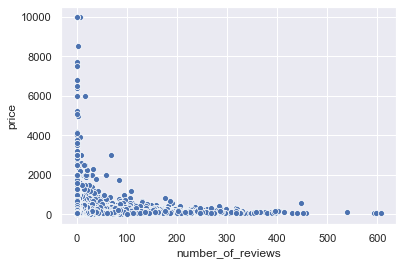

In [16]:
price_reviews = manhattan_data[['price', 'number_of_reviews']]

ax = sns.scatterplot(x='number_of_reviews', y='price', data=price_reviews)

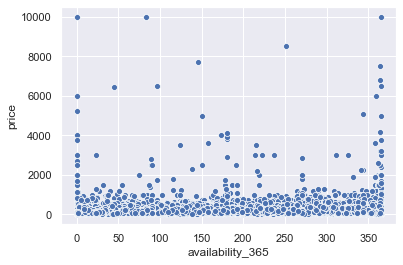

In [17]:
price_avail = manhattan_data[['price', 'availability_365']]

ax = sns.scatterplot(x='availability_365', y='price', data=price_avail)

## Data Analysis

### Splicing the data

#### Average Price of Airbnb Rentals in Manhattan

In [11]:
ave_price = pd.DataFrame(manhattan_data.groupby(['neighbourhood', 'room_type'])['price'].mean().sort_values(ascending=False))
ave_price.head(10)

,,price
neighbourhood,room_type,
Tribeca,Entire home/apt,561.818182
Battery Park City,Entire home/apt,488.541667
Flatiron District,Entire home/apt,388.000000
SoHo,Entire home/apt,365.618257
Theater District,Entire home/apt,318.182927
NoHo,Entire home/apt,308.492958
Greenwich Village,Entire home/apt,308.219931
Midtown,Entire home/apt,301.268182
Stuyvesant Town,Entire home/apt,294.166667


#### Average Availability of Airbnb Rentals in Manhattan

In [44]:
ave_avail = pd.DataFrame(manhattan_data.groupby(['neighbourhood', 'room_type'])['availability_365'].mean().sort_values(ascending=False))
ave_avail.head(10)

availability_365
neighbourhood      room_type                        
Battery Park City  Shared room            326.000000
Kips Bay           Shared room            243.333333
Lower East Side    Shared room            242.789474
Financial District Entire home/apt        213.830420
Theater District   Entire home/apt        202.158537
                   Private room           201.795082
Murray Hill        Entire home/apt        190.922306
Hell's Kitchen     Shared room            189.282828
Chelsea            Shared room            183.266667
Theater District   Shared room            183.000000

#### Average Number of Reviews of Airbnb Rentals in Manhattan

In [45]:
ave_reviews = pd.DataFrame(manhattan_data.groupby(['neighbourhood', 'room_type'])['number_of_reviews'].mean().sort_values(ascending=False))
ave_reviews.head(10)

,,number_of_reviews
neighbourhood,room_type,
Battery Park City,Shared room,205.000000
Nolita,Shared room,82.000000
Theater District,Shared room,60.000000
Chinatown,Shared room,47.500000
Hell's Kitchen,Private room,39.668155
East Harlem,Private room,35.687713
Chelsea,Private room,33.438849
West Village,Shared room,32.333333
SoHo,Shared room,32.000000


#### Average Minimum of Nights of Stay Required in Airbnb Rentals in Manhattan

In [46]:
ave_min_nights = pd.DataFrame(manhattan_data.groupby(['neighbourhood', 'room_type'])['minimum_nights'].median().sort_values(ascending=False))
ave_min_nights.head(10)

,,minimum_nights
neighbourhood,room_type,
Greenwich Village,Shared room,517.0
Murray Hill,Entire home/apt,29.0
Theater District,Entire home/apt,29.0
Lower East Side,Shared room,14.0
Stuyvesant Town,Entire home/apt,4.5
Roosevelt Island,Shared room,4.0
Tribeca,Entire home/apt,4.0
Midtown,Entire home/apt,4.0
Upper East Side,Entire home/apt,4.0


### Manhattan Airbnb Profiles

In [47]:
profiles = ave_price.merge(ave_reviews, on=['neighbourhood', 'room_type'])

In [49]:
profiles = profiles.merge(ave_avail, on=['neighbourhood', 'room_type'])

In [50]:
profiles = profiles.merge(ave_min_nights, on=['neighbourhood', 'room_type'])

In [54]:
profiles.head()

,,price,number_of_reviews,availability_365,minimum_nights
neighbourhood,room_type,,,,
Tribeca,Entire home/apt,561.818182,11.580420,140.762238,4.0
Battery Park City,Entire home/apt,488.541667,4.583333,86.479167,4.0
Flatiron District,Entire home/apt,388.000000,19.523077,126.830769,3.0
SoHo,Entire home/apt,365.618257,17.962656,106.663900,3.0
Theater District,Entire home/apt,318.182927,8.329268,202.158537,29.0


#### Examine first neighborhood

In [19]:
manhattan_data.loc[0, 'neighbourhood']

'Midtown'

Get the neighborhood's latitude and longitude values.

In [21]:
neighborhood_latitude = manhattan_data.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Midtown are 40.75362, -73.98376999999999.


In [22]:
manhattan_data.head()

,id,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2595,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
1,3647,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
2,5022,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
3,5099,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1,129
4,5178,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,1,220


In [24]:
manhattan_data.loc[0, 'latitude']

40.75362

In [25]:
manhattan_data.loc[0, 'longitude']

-73.98376999999999

#### Get nearby venues of first neighbourhood

<a id='item5'></a>

## Cluster Airbnbs

#### Set the features by which Airbnbs will be clustered

In [55]:
profiles.columns

Index(['price', 'number_of_reviews', 'availability_365', 'minimum_nights'], dtype='object')

In [56]:
features = ['price', 'number_of_reviews', 'availability_365', 'minimum_nights']
X = profiles[features]

#### Choose optimal number of clusters

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=14, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=17, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=18, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=19, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

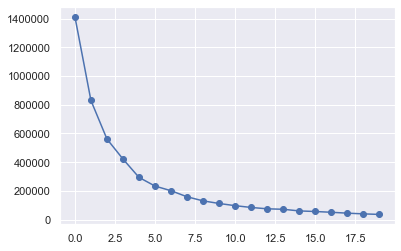

In [58]:
%matplotlib inline

# get the sum of squared errors and find where the reduction of the errors are saturated with the increase of k
squared_errors = []

for num_iter in range(1,21):
  km = KMeans(n_clusters=num_iter, random_state=42)
  km.fit(X)
  squared_errors.append(km.inertia_)

# check for the best k to use
plt.plot(squared_errors, marker = 'o')

#### Choosing 5 clusters

In [81]:
# Clustering using KMeans. We choose 5 clusters
km = KMeans(n_clusters=5, random_state=42)

# Fit data to model
km.fit(X)

# Get labels
labels = km.predict(X)

# Create new dataframe with features and labels
new_data = X.copy()

# Add labels to new_data dataframe
new_data['labels'] = labels

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

### Deep dive to each cluster

In [82]:
print(profiles.price.max())
print(profiles.number_of_reviews.max())
print(profiles.availability_365.max())
print(profiles.minimum_nights.max())

561.8181818181819
205.0
326.0
517.0


In [83]:
print(profiles.price.min())
print(profiles.number_of_reviews.min())
print(profiles.availability_365.min())
print(profiles.minimum_nights.min())

43.333333333333336
0.0
3.0
1.0


#### Cluster 0

In [92]:
# Cluster 0
cluster_0 = new_data[new_data['labels']==0]
cluster_0

,,price,number_of_reviews,availability_365,minimum_nights,labels
neighbourhood,room_type,,,,,
Two Bridges,Entire home/apt,169.076923,25.384615,64.192308,3.0,0
NoHo,Private room,166.142857,23.857143,101.428571,2.0,0
Financial District,Private room,165.623457,12.339506,118.617284,3.0,0
Chelsea,Private room,156.741007,33.438849,114.830935,2.0,0
Morningside Heights,Entire home/apt,148.906667,7.573333,26.040000,3.0,0
SoHo,Shared room,147.500000,32.000000,41.000000,1.5,0
Flatiron District,Private room,142.266667,10.000000,106.666667,1.0,0
Murray Hill,Private room,137.802632,16.828947,85.697368,2.0,0
Washington Heights,Entire home/apt,137.270270,14.949324,95.094595,3.0,0


Slightly expensive price, decent number of reviews, rarely available, minimum of two nights stay

#### Cluster 1

In [91]:
# Cluster 1
cluster_1 = new_data[new_data['labels']==1]
cluster_1

,,price,number_of_reviews,availability_365,minimum_nights,labels
neighbourhood,room_type,,,,,
Theater District,Entire home/apt,318.182927,8.329268,202.158537,29.0,1
NoHo,Entire home/apt,308.492958,11.647887,101.859155,3.0,1
Greenwich Village,Entire home/apt,308.219931,16.113402,88.360825,3.0,1
Midtown,Entire home/apt,301.268182,11.911818,166.964545,4.0,1
Stuyvesant Town,Entire home/apt,294.166667,20.333333,84.000000,4.5,1
Nolita,Entire home/apt,293.430303,23.175758,74.642424,3.0,1
Little Italy,Entire home/apt,291.000000,24.092105,120.934211,3.0,1
Chelsea,Entire home/apt,283.262195,17.125610,112.445122,3.0,1
West Village,Entire home/apt,278.724349,18.197550,84.479326,3.0,1


Expensive, decent reviews, available almost half the time, but has to stay a minimum of four nights

#### Cluster 2

In [90]:
# Cluster 2
cluster_2 = new_data[new_data['labels']==2]
cluster_2

,,price,number_of_reviews,availability_365,minimum_nights,labels
neighbourhood,room_type,,,,,
Tribeca,Entire home/apt,561.818182,11.580420,140.762238,4.0,2
Battery Park City,Entire home/apt,488.541667,4.583333,86.479167,4.0,2
Flatiron District,Entire home/apt,388.000000,19.523077,126.830769,3.0,2
SoHo,Entire home/apt,365.618257,17.962656,106.663900,3.0,2


Luxurious and way too expensive price, not overwhelmingly reviewed, available almost half the time, minimum stay of three nights

#### Cluster 3

In [89]:
# Cluster 3
cluster_3 = new_data[new_data['labels']==3]
cluster_3

,,price,number_of_reviews,availability_365,minimum_nights,labels
neighbourhood,room_type,,,,,
Greenwich Village,Shared room,83.0,0.5,182.5,517.0,3


Cheapest place to stay, not reviewed as much, available half the time, but has to be rented

#### Cluster 4

In [88]:
# Cluster 4
cluster_4 = new_data[new_data['labels']==4]
cluster_4

,,price,number_of_reviews,availability_365,minimum_nights,labels
neighbourhood,room_type,,,,,
Theater District,Private room,156.459016,23.409836,201.795082,1.0,4
Chelsea,Shared room,140.666667,20.133333,183.266667,1.0,4
Hell's Kitchen,Shared room,95.838384,20.131313,189.282828,1.0,4
Kips Bay,Shared room,89.111111,3.777778,243.333333,2.0,4
Theater District,Shared room,79.000000,60.000000,183.000000,2.0,4
Battery Park City,Shared room,55.000000,205.000000,326.000000,1.0,4
Lower East Side,Shared room,50.736842,10.789474,242.789474,14.0,4


More cheaper choices, reviewed quite a number of times, available half the time, and only requires a stay of one night

## Recommendations

Should you ever find yourself in need of accommodations in Manhattan, I have several recommendations depending on what you're looking for and of course, budget. The cheaper choices but reviewed an acceptable number of times are in Cluster 4. These are also available most of the year and only require you to stay a night or two. This is advisable for those who are only in Manhattan for a short period of time. Unfortunately, your choices are limited to a shared room. Choosing to rent a private room will be more expensive. If the budget is slightly higher than average, Cluster 0 is your friend. This cluster offers a wide variety of choices ranging across different price budgets and room preferences; there are even entire apartments available at this price. These rentals get a decent number of reviews, but are rarely available. Required minimum nights of stay is still reasonable from one to four nights. Cluster 1 is fairly similar to Cluster 0 and can accommodate the same preferences except price. The prices of rentals in Cluster 1 can be higher with the same characteristics of rentals from Cluster 0. This is because there are more rentals for entire apartments in Cluster 1. Lastly, if luxurious is the preference, then Cluster 2 is the best choice. The prices of rentals in this cluster are really expensive, but you get premium locations: Tribeca, Battery Park City, Flatiron District, and SoHo. Really, the location is what you'll be paying for in these rentals.